# Resnet Classification to ImageNet Categories

Interesting tasks
 - change is_training on True
 - compare various images
 - inspect reset model

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [151]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pickle
import os
import shutil
from utils.data import get_image_from_url
from utils.data import init_dir

In [152]:
from tensorflow.contrib.slim.nets import resnet_v1
from tensorflow.contrib import slim

## Load Data

In [257]:
url = "https://www.petakids.com/wp-content/uploads/2016/10/Brown-Hamster.jpg"
img_shape = [224, 224, 3]

In [258]:
img = get_image_from_url(url, img_shape)

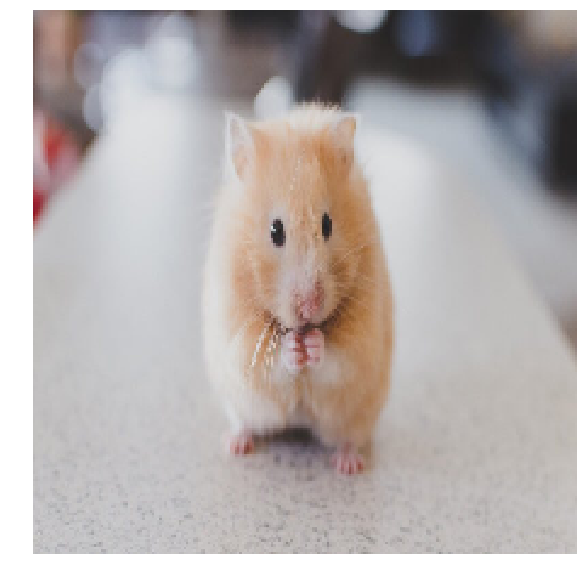

In [259]:
plt.figure(figsize=(10, 10))
plt.imshow(img[0].reshape(img_shape).astype(np.uint8))
ax = plt.gca()
ax.axes.set_axis_off()

## Build Resnet Graph

 - https://github.com/tensorflow/models/tree/master/research/slim 
 - https://github.com/tensorflow/models/blob/master/research/slim/nets/resnet_v1.py
 - resnet_arg_scope: list of nodes with default parameter settings
 - resnet_arg_scope returns slim_argscope instance       

In [260]:
resnet_model_ckpt = '/data/checkpoints/resnet_v1_50.ckpt'
renset_class_names = '/data/checkpoints/resnet_v1_50_catnames.pickle'

with open(renset_class_names, 'rb') as fr:
    imagenet_category_names = pickle.load(fr)

img = np.array(img).reshape([1,224,224,3])

In [261]:
graph = tf.Graph()
with graph.as_default():
    with tf.variable_scope('resnet_inputs'):
        images = tf.placeholder(tf.float32, shape=[None, 224, 224, 3])
        is_training = tf.placeholder(tf.bool)
        
    with slim.arg_scope(resnet_v1.resnet_arg_scope()):
        raw_prediction, othere_layers = resnet_v1.resnet_v1_50(
            images, output_stride=None, num_classes=1000, global_pool=True,
            is_training=is_training, scope='resnet_v1_50')
        
    with tf.name_scope('softmax_prediction'):
        prediction = tf.nn.softmax(tf.reshape(raw_prediction, shape=(-1, 1000)))
    
    init_resnet = slim.assign_from_checkpoint_fn(resnet_model_ckpt, slim.get_model_variables('resnet_v1_50'))
    
    initialize_vars = tf.group(
        tf.global_variables_initializer(),
        tf.local_variables_initializer())

## Init Model Logging

In [262]:
from utils.data import init_model_logging
base_dir = '/tensorboard_summaries/resnet/'
exp_name = 'experiment_1'

logging_meta = init_model_logging(base_dir, exp_name, graph=graph, remove_existing=True)

## Run Net

In [263]:
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True
        
with tf.Session(graph=graph, config=config) as session:
    session.run([initialize_vars])
    init_resnet(session)
    _prediction, = session.run([prediction], feed_dict={is_training: False, images: img})

INFO:tensorflow:Restoring parameters from /data/checkpoints/resnet_v1_50.ckpt


## Results

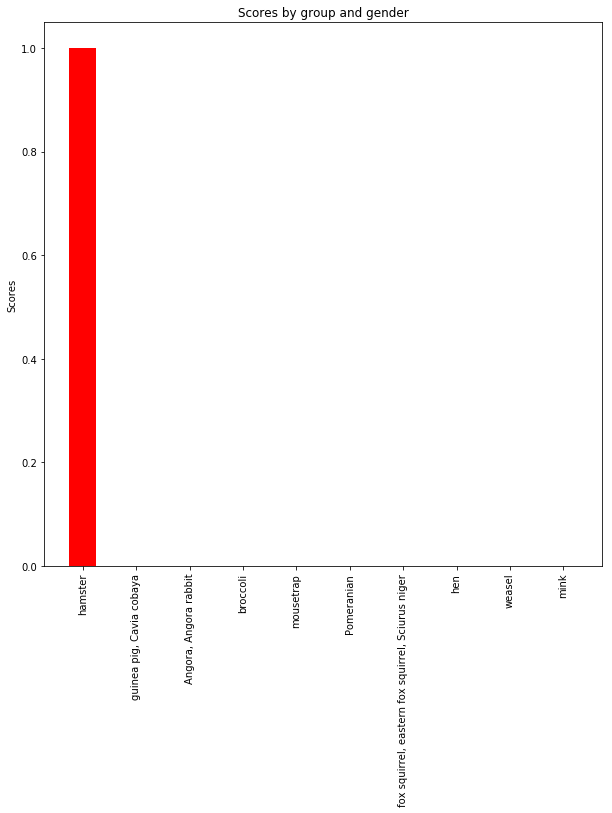

In [264]:
output_softmax = _prediction[0]
top_n = 10

figure = plt.figure(figsize=(10, 10))

top_label_class_ids = np.argsort(output_softmax)[-1:0:-1][:top_n]
top_label_class_scores = output_softmax[top_label_class_ids]

ax = plt.gca()
rects = ax.bar(np.arange(top_n), top_label_class_scores, 0.5, color='r')

ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
results = plt.xticks(np.arange(top_n), [imagenet_category_names[cat_id] for cat_id in top_label_class_ids], rotation='vertical')


## Create corrupted image

In [265]:
imagenet_category_names

{0: 'tench, Tinca tinca',
 1: 'goldfish, Carassius auratus',
 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 3: 'tiger shark, Galeocerdo cuvieri',
 4: 'hammerhead, hammerhead shark',
 5: 'electric ray, crampfish, numbfish, torpedo',
 6: 'stingray',
 7: 'cock',
 8: 'hen',
 9: 'ostrich, Struthio camelus',
 10: 'brambling, Fringilla montifringilla',
 11: 'goldfinch, Carduelis carduelis',
 12: 'house finch, linnet, Carpodacus mexicanus',
 13: 'junco, snowbird',
 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea',
 15: 'robin, American robin, Turdus migratorius',
 16: 'bulbul',
 17: 'jay',
 18: 'magpie',
 19: 'chickadee',
 20: 'water ouzel, dipper',
 21: 'kite',
 22: 'bald eagle, American eagle, Haliaeetus leucocephalus',
 23: 'vulture',
 24: 'great grey owl, great gray owl, Strix nebulosa',
 25: 'European fire salamander, Salamandra salamandra',
 26: 'common newt, Triturus vulgaris',
 27: 'eft',
 28: 'spotted salamander, Ambystoma 

In [266]:
corrupt_id = 333

In [267]:
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True
        
with tf.Session(graph=graph, config=config) as session:
    session.run([initialize_vars])
    init_resnet(session)
    
    fake_imgs = np.zeros((30, 224, 224, 3))
    fake_imgs = fake_imgs + img[0]
    
    for iteration in range(100):
        if iteration == 0:
            top_ids = np.arange(0,10)
        else:
            top_ids = np.argsort(_prediction[:, corrupt_id])[:10]
            print(min(_prediction[:, corrupt_id]))
            if min(_prediction[:, corrupt_id]) < 0.3:
                break
        noise1 = np.random.randn(10, 224, 224, 3)
        noise2 = np.random.randn(10, 224, 224, 3)

        tmp_imgs = np.zeros([30, 224, 224, 3])
        tmp_imgs[:10] = fake_imgs[top_ids]
        tmp_imgs[10:20] = fake_imgs[top_ids] + noise1
        tmp_imgs[20:] = fake_imgs[top_ids] + noise2
        fake_imgs = np.clip(tmp_imgs, 0, 255)
            
        _prediction, = session.run([prediction], feed_dict={is_training: False, images: fake_imgs})

INFO:tensorflow:Restoring parameters from /data/checkpoints/resnet_v1_50.ckpt
0.999557
0.999515
0.999501
0.999479
0.99943
0.999355
0.999288
0.999288
0.99925
0.999173
0.99905
0.998979
0.998662
0.998662
0.998588
0.998426
0.998286
0.998133
0.998066
0.997683
0.99699
0.99699
0.996785
0.996613
0.996567
0.996273
0.995887
0.995713
0.995382
0.994846
0.993626
0.993144
0.992855
0.992855
0.989383
0.989383
0.989383
0.988446
0.98825
0.986215
0.986215
0.984896
0.984896
0.984896
0.98297
0.981853
0.98148
0.98148
0.978381
0.978381
0.977482
0.977482
0.97339
0.97339
0.97339
0.97339
0.970454
0.970454
0.969665
0.964146
0.964146
0.964146
0.960948
0.960948
0.960796
0.960017
0.954303
0.954303
0.954303
0.951985
0.950332
0.950086
0.950086
0.950086
0.944777
0.939206
0.933496
0.923082
0.923082
0.913192
0.905514
0.89993
0.89993
0.89993
0.896919
0.886287
0.878846
0.878846
0.874038
0.871893
0.860668
0.860668
0.853124
0.853124
0.851088
0.848066
0.841996
0.826687
0.826687


In [269]:
np.where(_prediction[:, corrupt_id]<0.85)

(array([ 0,  1,  2,  3,  4,  5, 10, 21, 22, 23, 25]),)

In [270]:
idx = 0

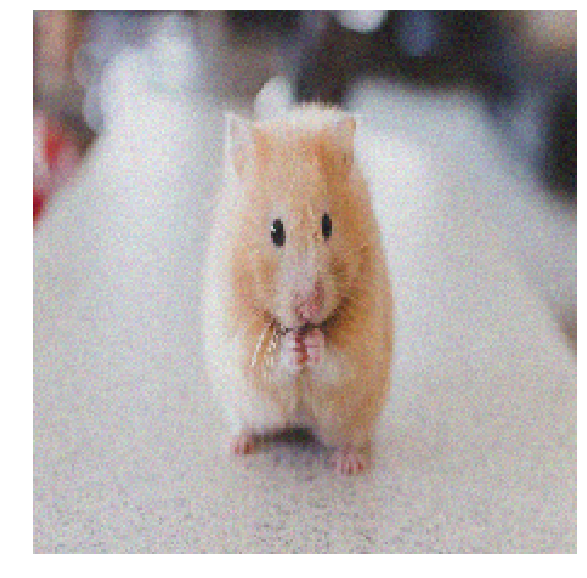

In [271]:
plt.figure(figsize=(10, 10))
plt.imshow(fake_imgs[idx].reshape(img_shape).astype(np.uint8))
ax = plt.gca()
ax.axes.set_axis_off()

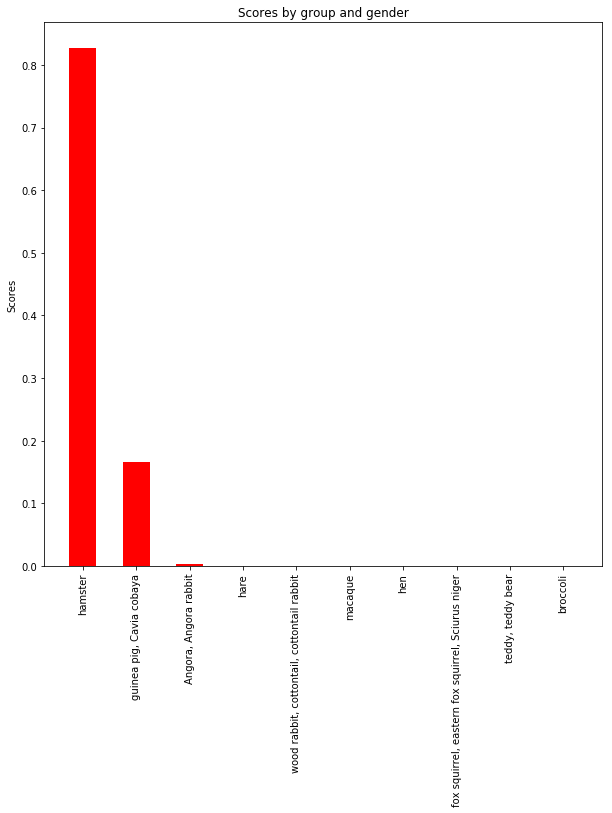

In [272]:
output_softmax = _prediction[idx]
top_n = 10

figure = plt.figure(figsize=(10, 10))

top_label_class_ids = np.argsort(output_softmax)[-1:0:-1][:top_n]
top_label_class_scores = output_softmax[top_label_class_ids]

ax = plt.gca()
rects = ax.bar(np.arange(top_n), top_label_class_scores, 0.5, color='r')

ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
results = plt.xticks(np.arange(top_n), [imagenet_category_names[cat_id] for cat_id in top_label_class_ids], rotation='vertical')
